# Example `KBackground.Estimator` workflow with Kepler TPFs

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from kbackground import Estimator
import astropy.units as u

In [5]:
import kbackground
kbackground.log.setLevel("DEBUG")

First we are going to get a number of the TPFs in a large superstamp in campaign 8. This will let us see a patch of data with a rolling band.

In [6]:
tpfs = lk.search_targetpixelfile('KIC 8557374', quarter=5, cadence='long', radius=10 * u.arcmin).download_all()

Next we will extract the row, column and flux values from all the TPFs.

In [7]:
rows, columns, fluxs, mission_bkgs, cadencenos = [], [], [], [], []
for tpf in tpfs:
    column, row = np.meshgrid(np.arange(tpf.column, tpf.shape[2] + tpf.column), np.arange(tpf.row, tpf.shape[1] + tpf.row))
    aper = np.nansum(tpf.flux.value, axis=0) != 0
    rows.append(row[aper])
    columns.append(column[aper])
    fluxs.append(tpf.flux.value[:, aper] + np.nan_to_num(tpf.flux_bkg.value[:, aper]))
    cadencenos.append(tpf.cadenceno)

Next we can build the `Estimator` object, passing in the row, column, and flux values from all the TPFs.

In [8]:
r, c, f = np.hstack(rows), np.hstack(columns), np.hstack(fluxs)
k = np.isfinite(f).all(axis=0)

In [10]:
e = Estimator(cadencenos[0], r[k], c[k], f[:, k])

2022-01-20 17:54:18,213 - kbackground.kbackground - DEBUG - new `kbackground` Object. tknotspacing:10, xknotspacing:10
2022-01-20 17:54:18,214 - kbackground.kbackground - DEBUG - ntimes x npixels : (4492, 2194)
2022-01-20 17:54:18,759 - kbackground.kbackground - DEBUG - unq_row : 875 ... 1042 (148 unique rows)
2022-01-20 17:54:18,760 - kbackground.kbackground - DEBUG - Binning flux data
2022-01-20 17:54:18,782 - kbackground.kbackground - DEBUG - Binned flux data
2022-01-20 17:54:18,783 - kbackground.kbackground - DEBUG - Making A
2022-01-20 17:54:18,788 - kbackground.kbackground - DEBUG - Made `x_spline` ((148, 60))
2022-01-20 17:54:18,973 - kbackground.kbackground - DEBUG - Made `t_spline` ((4492, 469))
2022-01-20 17:54:19,358 - kbackground.kbackground - DEBUG - Made `X` ((664816, 60))
2022-01-20 17:54:19,362 - kbackground.kbackground - DEBUG - Made `T` ((664816, 469))
2022-01-20 17:54:21,268 - kbackground.kbackground - DEBUG - Made `A1`
2022-01-20 17:54:21,309 - kbackground.kbackgrou

In [ ]:
e.plot();

### Correction for faint pixels

Below we show the correction for a subset of the faint pixels in this dataset. The correction largely removes the long term trends from the dataset.

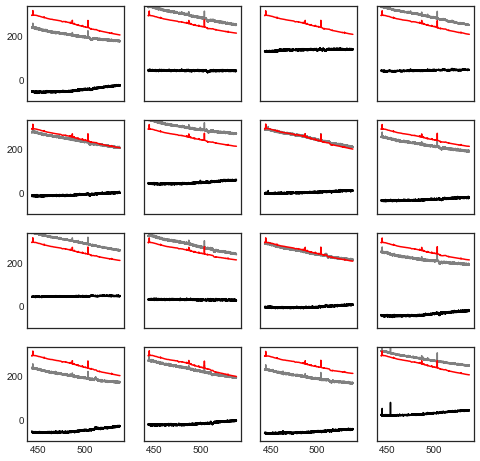

In [36]:
dim_pix = np.where(np.diff(np.nanpercentile(e.flux, (5, 95), axis=0), axis=0)[0] < 80)[0]
fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
kdx = -1
for idx, jdx in enumerate(np.random.choice(dim_pix, 16)):
    if idx % 4 == 0:
        kdx += 1
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx], label='Data', c='grey')
    ax[kdx, idx % 4].plot(tpf.time.value, e.flux[:, jdx] - e.model[:, jdx], label='Data', c='k')
    ax[kdx, idx % 4].plot(tpf.time.value, e.model[:, jdx], label='Model', c='r')
    ax[kdx, idx % 4].set(ylim=(-100, ax[kdx, idx % 4].get_ylim()[1]))